# Unsupervised Learning Hands On 

## 1. Download data of today's example:


**Gene expression data for cancer samples from the TCGA database**: using the xenaPython module 

In [20]:
import numpy as np
import pandas as pd
import xenaPython as xena
import re

def trasform_codes(code_list,code_keys): 
  keys=re.split(r'\t', code_keys)  
  not_nan_indices = [i for i, x in enumerate(code_list) if x != "NaN"];   
  for i in not_nan_indices :
      code_list[i]=keys[code_list[i]]
  return code_list


hub = "https://tcga.xenahubs.net"
all_datasets=np.array(xena.all_datasets(hub))

target_data_type='HiSeqV2_PANCAN'
#RSEM in log2(x+1), pan-cancer normalized, https://xenabrowser.net/datapages/?dataset=TCGA.BLCA.sampleMap%2FHiSeqV2_PANCAN&host=https%3A%2F%2Ftcga.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443 
clinical_data_type='clinicalMatrix'
clinical_fields=[ 'clinical_stage', 'days_to_birth', 'gender', 'vital_status', 'days_to_last_followup']
clinical_fields_alt=[ 'pathologic_stage', 'days_to_birth', 'gender', 'vital_status', 'days_to_last_followup']
clinical_fields_legends=['stage', 'age', 'gender', 'status', 'time']
print("Will read the following clinical information: {}".format(clinical_fields))

samplesToSkip=["COADREAD","LUNG"]

minimal_number_of_samples=200

my_gene_universe=0
gene_names=[]
gene_expression_matrix=[]
clinical_matrix=[]
my_cancer_types=[]
my_cancer_types_clinical=[]

#check how many datasets we can use
#save them in 'my_cancer_types'

for entry in all_datasets:
  if entry['name'][-len(target_data_type):]==target_data_type:   
    dataset=entry['name']
    datasetCancerType=dataset[:dataset.find(target_data_type)-1]; datasetCancerType=datasetCancerType[5:-10]
    my_cancer_types.append(datasetCancerType)
    if my_gene_universe==0:
        my_gene_universe=xena.dataset_field_n (hub, dataset)
    else:
        if (my_gene_universe!=xena.dataset_field_n (hub, dataset)):
            print("ERROR! DIFFERENT GENE NUMBER!")
    gene_names=xena.dataset_field (hub, dataset)
    samples=xena.dataset_samples(hub, dataset, None)
    
    if (len(samples)!=len(np.unique(np.array(samples)))):
        print("WARNING: duplicate sample names for {}".format(datasetCancerType))
    
    gene_exp_list=xena.dataset_fetch(hub, dataset, samples, gene_names) 
    gene_exp_list=np.transpose(np.array(gene_exp_list))    
    gene_exp_list=pd.DataFrame(gene_exp_list)
    gene_exp_list.columns = gene_names
    gene_exp_list=gene_exp_list.drop(columns=['psiTPTE22', 'sampleID', 'tAKR'])

    if (len(samples)!=gene_exp_list.shape[0]):
        print("WARNING: duplicate sample information for {}".format(datasetCancerType))
     
    gene_exp_list.index=samples 
    if len(gene_expression_matrix)==0:
        gene_expression_matrix=gene_exp_list
    else:
        gene_expression_matrix=pd.concat([gene_expression_matrix,gene_exp_list], axis=0)

  elif entry['name'][-len(clinical_data_type):]==clinical_data_type:  
    dataset=entry['name']
    datasetCancerTypeClin=dataset[5:dataset.find('sampleMap')-1]
    samples=xena.dataset_samples(hub, dataset, None); 
    
    if (datasetCancerTypeClin in samplesToSkip):
        print("Will skip cancer type {}".format (datasetCancerTypeClin))
        continue
    
    if len(samples) < minimal_number_of_samples :
        print("WARNING: {} has fewer than {} samples".format(datasetCancerTypeClin,minimal_number_of_samples))
        print("Will skip this cancer type")
        continue
    
    my_code_list=xena.field_codes(hub, dataset, clinical_fields)
    my_codes_clinical=xena.dataset_fetch(hub, dataset, samples, clinical_fields)
    
    alt=False
    if len(clinical_fields)!=len(my_code_list) :
        print("WARNING: will use pathologic_stage instead of clinical_stage for {}".format(datasetCancerTypeClin))
        my_code_list=xena.field_codes(hub, dataset, clinical_fields_alt)
        my_codes_clinical=xena.dataset_fetch(hub, dataset, samples, clinical_fields_alt)
        alt=True
        if len(clinical_fields_alt)!=len(my_code_list) :
            print("WARNING: not all clinical fields available for samples from {}".format(datasetCancerTypeClin))
            print("Will skip this cancer type")
            continue
    my_cancer_types_clinical.append(datasetCancerTypeClin)
    my_clinical_features_local= []
    for i in range(len(my_code_list)) :
        my_field=my_code_list[i]['name']
        if alt :
            j=clinical_fields_alt.index(my_field)            
        else :
            j=clinical_fields.index(my_field)
        if(my_code_list[i]['code']!=None) :
            my_codes_clinical[j]=trasform_codes(my_codes_clinical[j],my_code_list[i]['code'])
        my_clinical_features_local.append(my_codes_clinical[i])
    my_clinical_features_local=np.transpose(np.array(my_clinical_features_local))
    my_clinical_features_local=pd.DataFrame(my_clinical_features_local)
    my_clinical_features_local.columns = clinical_fields_legends
    my_clinical_features_local.index=samples 
    my_clinical_features_local['type']=datasetCancerTypeClin
    if len(clinical_matrix)==0:
        clinical_matrix=my_clinical_features_local
    else:
        clinical_matrix=pd.concat([clinical_matrix,my_clinical_features_local], axis=0)
        
print("Will use {} datasets".format(len(my_cancer_types_clinical)))
print(my_cancer_types_clinical)

#remove duplicated patients (completely) from the expression matrix
mylistpatientswithexpression=gene_expression_matrix.index.values.tolist()
myDuplicateValues=[]
for elem in mylistpatientswithexpression:
    if mylistpatientswithexpression.count(elem) > 1:
        myDuplicateValues.append(elem)
print("WARNING: will exclude {} values as duplicates". format(len(myDuplicateValues)))
gene_expression_matrix=gene_expression_matrix.drop(myDuplicateValues)

full_df=gene_expression_matrix.merge(clinical_matrix, left_index=True, right_index=True)
print("Will use {} patients".format(full_df.shape[0]))


Will read the following clinical information: ['clinical_stage', 'days_to_birth', 'gender', 'vital_status', 'days_to_last_followup']
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip cancer type COADREAD
Will skip cancer type LUNG
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will skip this cancer type
Will use 16 datasets
['OV', 'KIRC', 'COAD', 'LUSC', 'LUAD', 'KIRP', 'CESC', 'SKCM', 'BLCA', 'BRCA', 'UCEC', 'LIHC', 'THCA', 'HNSC', 'ESCA', 'STAD']
Will use 6071 patients


**2. Exclude patients with missed information:**

In [21]:
#exlude NA cells:
df_noNA=full_df

for colname in ['stage', 'age', 'gender', 'status', 'time']:
    if (sum(df_noNA[colname]=='NaN')>0):
        patient_to_exclude=df_noNA.index.values[np.where(df_noNA[colname]=='NaN')]
        df_noNA=df_noNA.drop(patient_to_exclude)
print("Number of patients without NA: {}".format(df_noNA.shape[0]))



Number of patients without NA: 4561


**3. Get summary statistics about the remaining patients:**

In [22]:
import pandas_profiling #v2.4: conda install -c conda-forge/label/cf202003 pandas-profiling 

profile = pandas_profiling.ProfileReport(df_noNA[['stage', 'age', 'gender', 'status', 'time','type']], title='Pandas Profiling Report', html={'style':{'full_width':True}},minimal=True)
profile.to_notebook_iframe()
#Do some more cleaning based on the report:
df_noNA = df_noNA[(df_noNA['status']!='[Discrepancy]') & (df_noNA['time']!='[Discrepancy]')]

df_noNA['age']=[int(i) for i in df_noNA['age']]  
df_noNA['time']=[int(i) for i in df_noNA['time']]  
profile = pandas_profiling.ProfileReport(df_noNA[['stage', 'age', 'gender', 'status', 'time','type']], title='Pandas Profiling Report', html={'style':{'full_width':True}},minimal=True)
profile.to_notebook_iframe()

# Visualize the data: Dimention reduction
**4. Create X and y**

**Assign colors to tumor types**

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

X = df_noNA.drop(columns=['stage', 'age', 'gender', 'status', 'time','type'])
y = df_noNA['type']

num_cancer_type=len(set(y))
current_palette = sns.color_palette("colorblind")+sns.color_palette("dark")+sns.color_palette("deep")
current_palette=current_palette[0:num_cancer_type]
#visualize the palette if needed:
#sns.palplot(current_palette)
colors = current_palette

**5. Run PCA and incremental PCA**:

---Incremental PCA: 20.070125102996826 seconds ---
---PCA: 3.3077328205108643 seconds ---


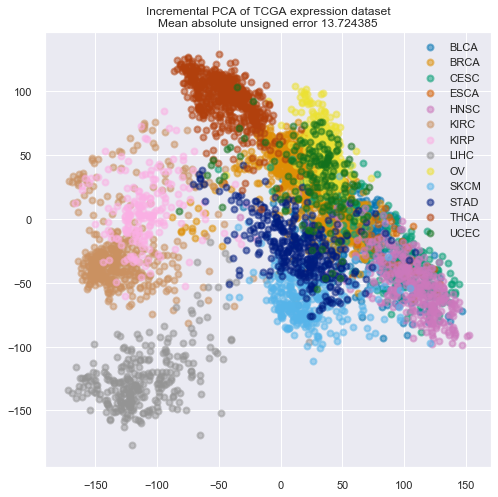

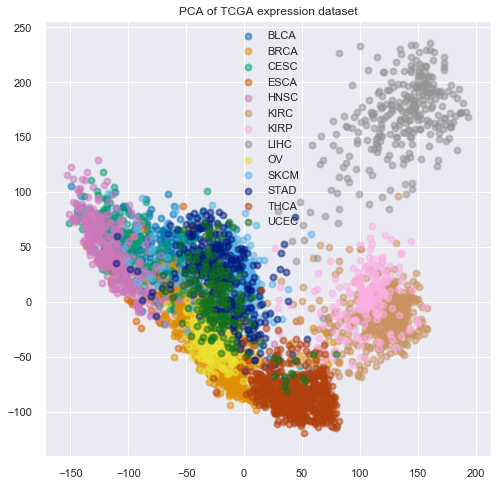

In [5]:
from sklearn.decomposition import PCA, IncrementalPCA
import time

n_components = 2

start_time = time.time()
ipca = IncrementalPCA(n_components=n_components, batch_size=10)
X_ipca = ipca.fit_transform(X)
print("---Incremental PCA: %s seconds ---" % (time.time() - start_time))

start_time = time.time()
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
print("---PCA: %s seconds ---" % (time.time() - start_time))

for X_transformed, title in [(X_ipca, "Incremental PCA"), (X_pca, "PCA")]:
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, range(num_cancer_type), np.unique(y)):
        plt.scatter(X_transformed[y == target_name, 0], X_transformed[y == target_name, 1],
                    color=color, lw=2, label=target_name, alpha=0.5)
    if "Incremental" in title:
        err = np.abs(np.abs(X_pca) - np.abs(X_ipca)).mean()
        plt.title(title + " of TCGA expression dataset\nMean absolute unsigned error "
                  "%.6f" % err)
    else:
        plt.title(title + " of TCGA expression dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)

plt.show()

**6. Plot other dimensions of PCA**:

---PCA: 3.608130931854248 seconds ---
PCA: PCs 1 and 2
PCA: PCs 3 and 4
PCA: PCs 5 and 6
PCA: PCs 7 and 8
PCA: PCs 9 and 10


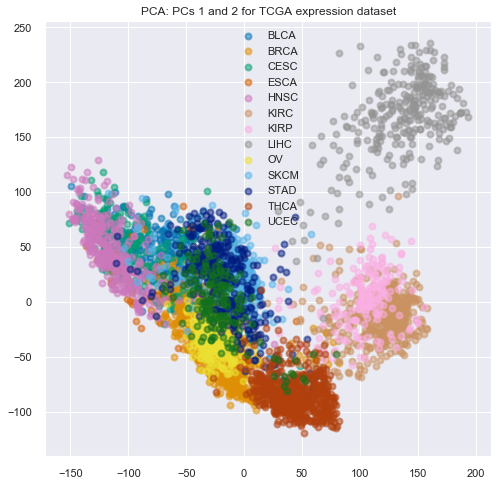

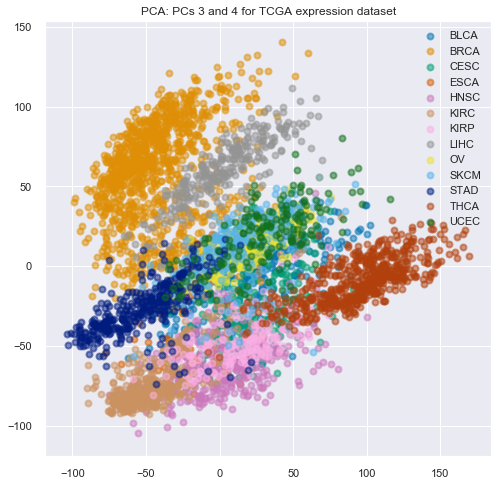

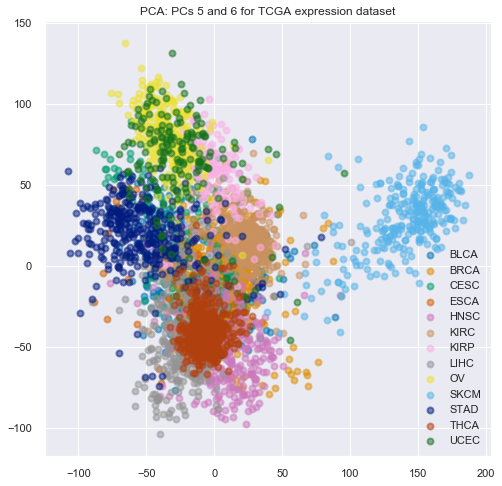

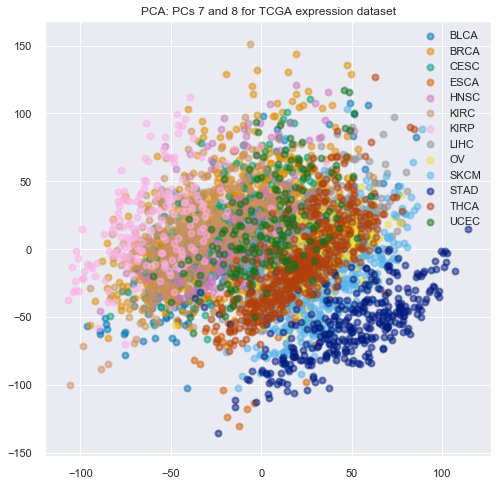

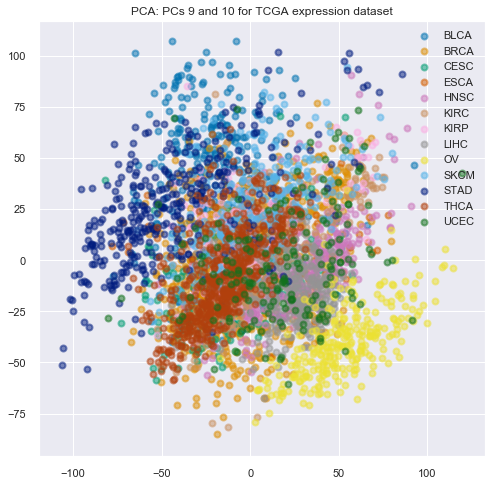

In [6]:
n_components = 10

start_time = time.time()
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
print("---PCA: %s seconds ---" % (time.time() - start_time))

for axes in [[0,1],[2,3],[4,5],[6,7],[8,9]]:
    title="PCA: PCs {} and {}".format(axes[0]+1,axes[1]+1)
    print(title)
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, range(num_cancer_type), np.unique(y)):
        plt.scatter(X_pca[y == target_name, axes[0]], X_pca[y == target_name, axes[1]],
                    color=color, lw=2, label=target_name, alpha=0.5)
    plt.title(title + " for TCGA expression dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)

plt.show()

**7. What proportion of variance is explained by the first PCs?** 

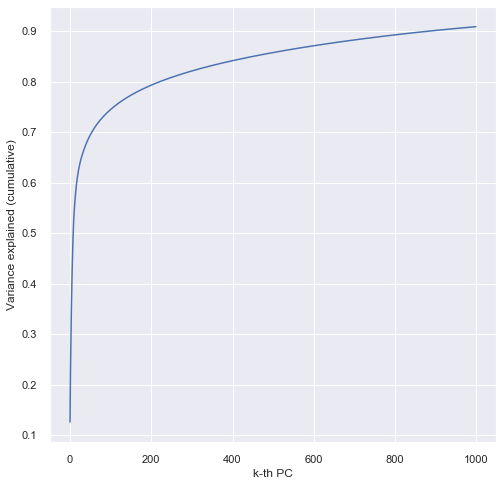

884


In [24]:
n_components = 1000
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 8))    
plt.plot(range(n_components), np.cumsum(pca.explained_variance_ratio_), 'bx-')
plt.xlabel('k-th PC')
plt.ylabel('Variance explained (cumulative)')
plt.show()

print(np.min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.9))+1)

**8. Run independent component analysis (ICA)**

---PCA: 6.103254079818726 seconds ---
---ICA (for the first 30 PCs)): 0.34558939933776855 seconds ---
ICA: ICs 1 and 2
ICA: ICs 3 and 4
ICA: ICs 5 and 6
ICA: ICs 7 and 8
ICA: ICs 9 and 10


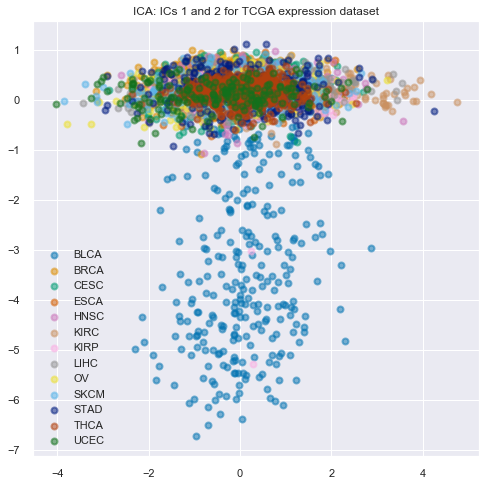

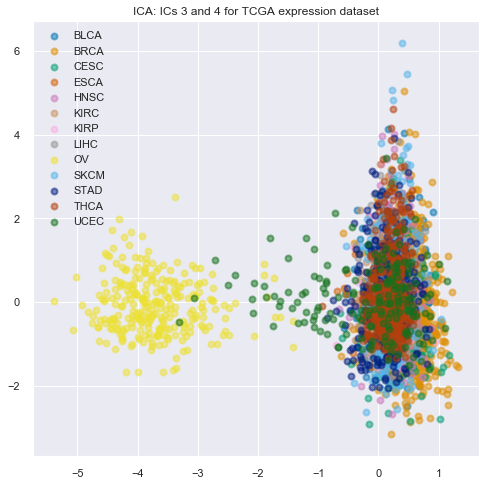

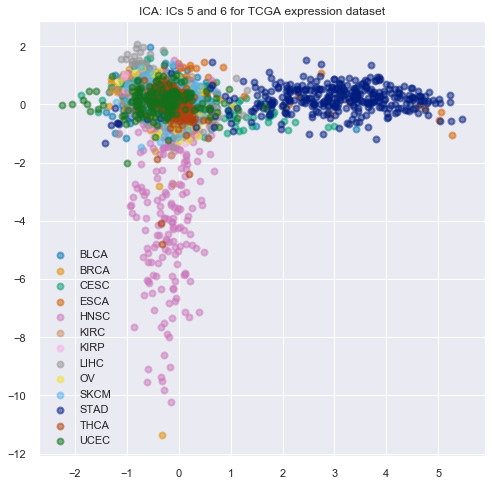

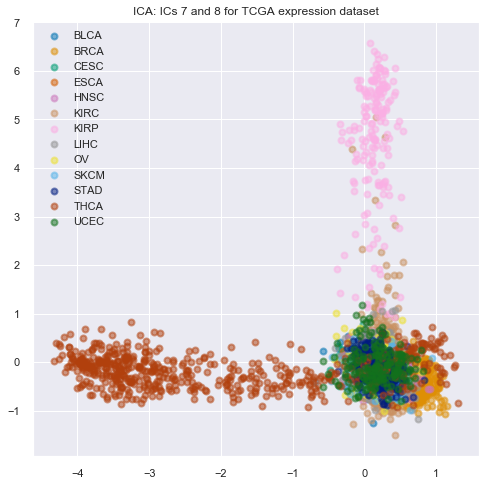

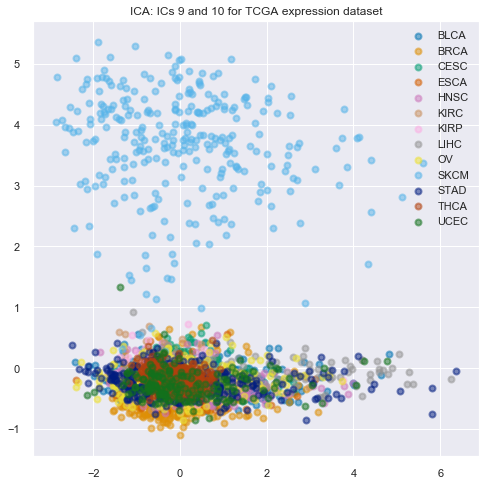

In [8]:
from sklearn.decomposition import FastICA

rng = np.random.RandomState(11)

#Takes ages:
#start_time = time.time()
#ica = FastICA(random_state=rng,n_components=n_components)
#S_ica_ = ica.fit(X).transform(X)  # Estimate the sources
#print("---ICA: %s seconds ---" % (time.time() - start_time))

#first perform PCA then search for ICs in the space of the first N PCs
n_components=30

start_time = time.time()
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
print("---PCA: %s seconds ---" % (time.time() - start_time))

start_time = time.time()
ica = FastICA(random_state=rng,n_components=n_components)
S_ica_ = ica.fit_transform(X_pca)  # Estimate the sources
print("---ICA (for the first {} PCs)): {} seconds ---".format(n_components, time.time() - start_time))

S_ica_ /= S_ica_.std(axis=0)

for axes in [[0,1],[2,3],[4,5],[6,7],[8,9]]:
    title="ICA: ICs {} and {}".format(axes[0]+1,axes[1]+1)
    print(title)
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, range(num_cancer_type), np.unique(y)):
        plt.scatter(S_ica_[y == target_name, axes[0]], S_ica_[y == target_name, axes[1]],
                    color=color, lw=2, label=target_name, alpha=0.5)
    plt.title(title + " for TCGA expression dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)

plt.show()


**9. Apply t-SNE dimention reduction:**

---PCA: 4.6040122509002686 seconds ---
---tSNE: 35.43154954910278 seconds ---


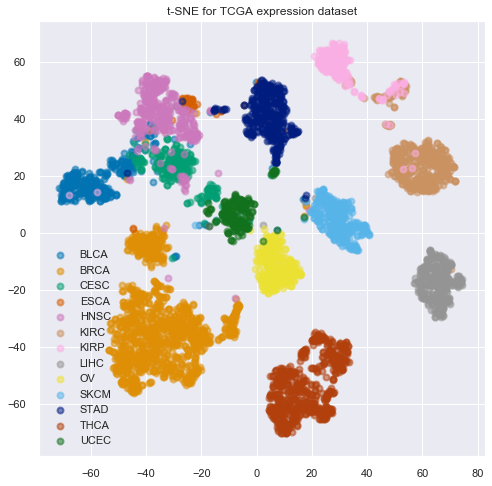

In [9]:
from sklearn.manifold import TSNE

#takes ages:
#start_time = time.time()
#n_components=2
#X_embedded = TSNE(n_components=n_components).fit_transform(X)
#print("---tSNE: %s seconds ---" % (time.time() - start_time))

#apply on the first N PCs:

n_componentsPCA=30

start_time = time.time()
pca = PCA(n_components=n_componentsPCA)
X_pca = pca.fit_transform(X)
print("---PCA: %s seconds ---" % (time.time() - start_time))

start_time = time.time()
n_components=2
perplexity_=30 #default value
X_embedded = TSNE(n_components=n_components, random_state=42, perplexity=perplexity_).fit_transform(X_pca)
print("---tSNE: %s seconds ---" % (time.time() - start_time))

title="t-SNE"
plt.figure(figsize=(8, 8))
for color, i, target_name in zip(colors, range(num_cancer_type), np.unique(y)):
    plt.scatter(X_embedded[y == target_name, 0], X_embedded[y == target_name, 1],
                    color=color, lw=2, label=target_name, alpha=0.5)
plt.title(title + " for TCGA expression dataset")
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.show()

**10. Apply UMAP dimention reduction**:


---UMAP (default, min_dist=.1, n_neighbors=15): 18.78019642829895 seconds ---
---UMAP (min_dist=0.5, n_neighbors=15): 11.590553998947144 seconds ---
---UMAP (min_dist=1.0, n_neighbors=15): 11.237061500549316 seconds ---


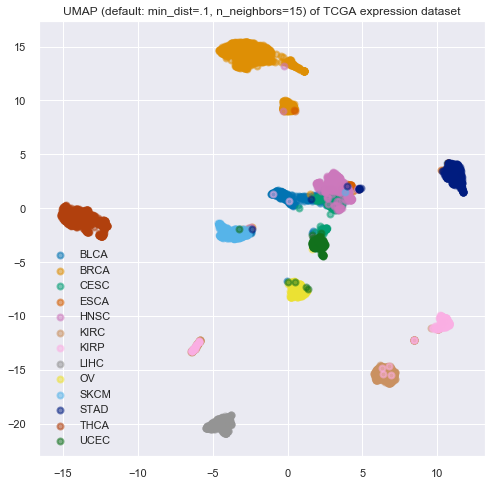

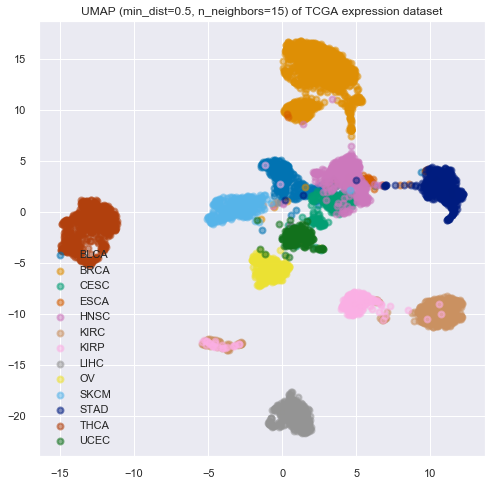

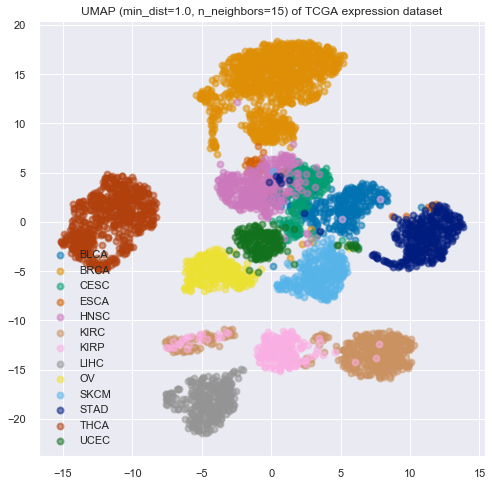

In [10]:
import umap # conda install -c conda-forge/label/cf202003 umap-learn
import warnings
warnings.filterwarnings('ignore')

#takes ages:
#start_time = time.time()
#umap_embedding = umap.UMAP().fit_transform(X) #takes ages
#print("---UMAP: %s seconds ---" % (time.time() - start_time))

#working with the first PC components instead:

start_time = time.time()
umap_embedding_default = umap.UMAP(min_dist=0.1, random_state=42, n_neighbors=15).fit_transform(X_pca)
print("---UMAP (default, min_dist=.1, n_neighbors=15): %s seconds ---" % (time.time() - start_time))

start_time = time.time()
umap_embedding05 = umap.UMAP(min_dist=0.5, random_state=42, n_neighbors=15).fit_transform(X_pca)
print("---UMAP (min_dist=0.5, n_neighbors=15): %s seconds ---" % (time.time() - start_time))

start_time = time.time()
umap_embedding1 = umap.UMAP(min_dist=1, random_state=42, n_neighbors=15).fit_transform(X_pca)
print("---UMAP (min_dist=1.0, n_neighbors=15): %s seconds ---" % (time.time() - start_time))


for X_transformed, title in [(umap_embedding_default, "UMAP (default: min_dist=.1, n_neighbors=15)"), (umap_embedding05, "UMAP (min_dist=0.5, n_neighbors=15)"),
                             (umap_embedding1, "UMAP (min_dist=1.0, n_neighbors=15)")]:
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, range(num_cancer_type), np.unique(y)):
        plt.scatter(X_transformed[y == target_name, 0], X_transformed[y == target_name, 1],
                    color=color, lw=2, label=target_name, alpha=0.5)
    plt.title(title + " of TCGA expression dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.show()

# Clustering

**11. k-means**

True number of clusters: 13
---KMeans (default parameters): 166.0594003200531 seconds ---
---MiniBatchKMeans (default parameters): 4.679474592208862 seconds ---


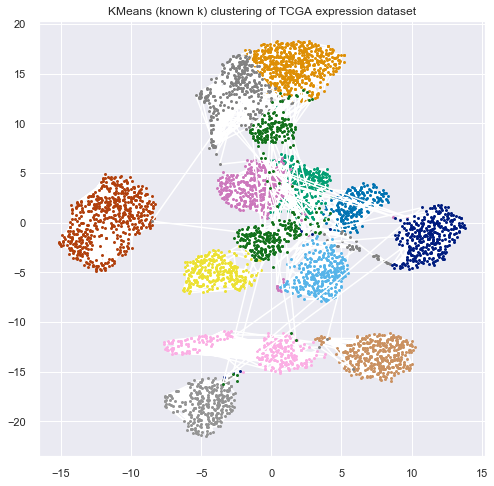

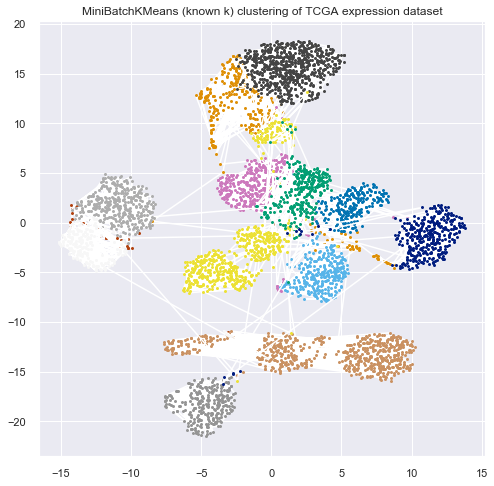

In [11]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

trueK=len(np.unique(y))
print("True number of clusters: {}".format(trueK))

cancer_centers=[]
#get true centers:
for i, target_name in zip(range(num_cancer_type), np.unique(y)):
    cancer_centers.append(X.loc[y==target_name].mean(axis=0))
cancer_centers=np.array(cancer_centers)
# Compute clustering with Means (known K)
k_means = KMeans(init='k-means++', n_clusters=trueK,random_state=42)
start_time = time.time()
k_means.fit(X)
print("---KMeans (default parameters): %s seconds ---" % (time.time() - start_time))

# Compute clustering with MiniBatchKMeans (known K)

mbk = MiniBatchKMeans(init='k-means++', n_clusters=trueK,batch_size=100,random_state=42) #default batch_size
start_time = time.time()
mbk.fit(X)
print("---MiniBatchKMeans (default parameters): %s seconds ---" % (time.time() - start_time))

def getnewcolors(order,colors):
    order=order.tolist()
    newcolors=[]
    myGreyPalette=sns.color_palette("Greys_r",len(order))
    duplicates=[]
    for i in range(len(order)):
        elem=order[i]
        newcolors.append(colors[elem])
        if order.count(elem) > 1:
            if elem in duplicates: #replace by grey color
                newcolors[i]=myGreyPalette[i]
            else: #first occ: do nothing
                duplicates.append(elem)
    return newcolors


for X_clustered, title in [(k_means, "KMeans (known k)"), (mbk, "MiniBatchKMeans (known k)")]:
    plt.figure(figsize=(8, 8))    
    
    # We want to have the same colors as in the original dataset (if possible)
    cluster_centers = X_clustered.cluster_centers_
    order = pairwise_distances_argmin(cluster_centers,cancer_centers)
    newcolors=getnewcolors(order,colors)    
    k_means_labels = X_clustered.fit_predict(X)    
    n_clusters=len(cluster_centers)
    for k, col in zip(range(n_clusters), newcolors):
        my_members = k_means_labels == k
        cluster_center = cluster_centers[k]
        plt.plot(umap_embedding1[my_members, 0], umap_embedding1[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    plt.title(title + " clustering of TCGA expression dataset")
   
plt.show()


### How to choose the best k?
**12. Elbow method**

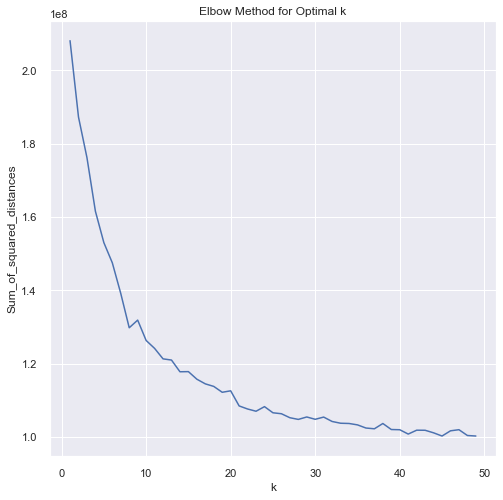

In [12]:
from sklearn.preprocessing import StandardScaler
#Elbow method:

#MiniBatchKMeans instead of k-means, as it is faster

Sum_of_squared_distances = []

K = range(1,50)
for k in K:
    km = MiniBatchKMeans(n_clusters=k, random_state=42)
    km = km.fit(X)
    sse=km.inertia_
    Sum_of_squared_distances.append(sse)   

plt.figure(figsize=(8, 8))    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method for Optimal k')

plt.show()



### How to choose the best k?
**13. Silhouette analysis**

For n_clusters = 7 The average silhouette_score is : 0.14424547941716304
For n_clusters = 8 The average silhouette_score is : 0.17937795795441785
For n_clusters = 9 The average silhouette_score is : 0.15677122005197028
For n_clusters = 10 The average silhouette_score is : 0.14455090564596598
For n_clusters = 11 The average silhouette_score is : 0.15394719849368912
For n_clusters = 12 The average silhouette_score is : 0.1714533858816391
For n_clusters = 13 The average silhouette_score is : 0.1305823523945136
For n_clusters = 14 The average silhouette_score is : 0.15355631953487484


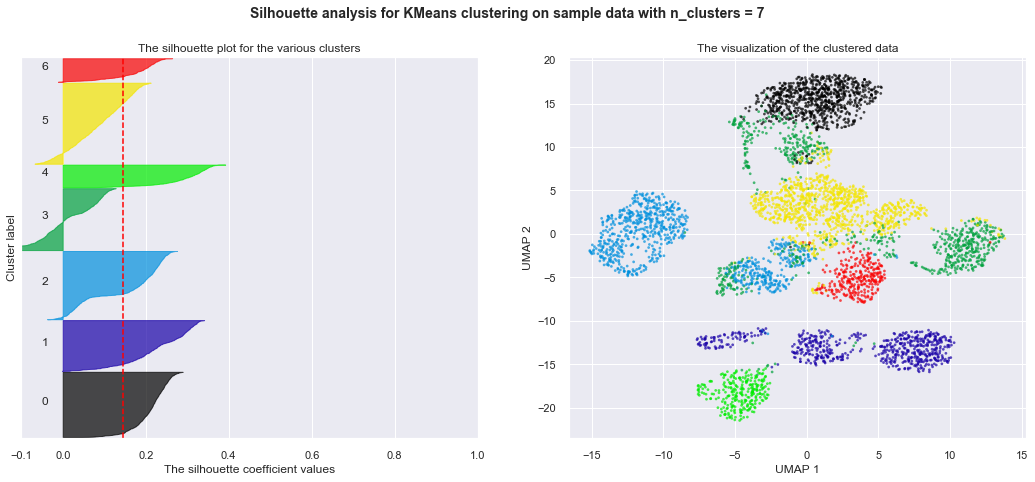

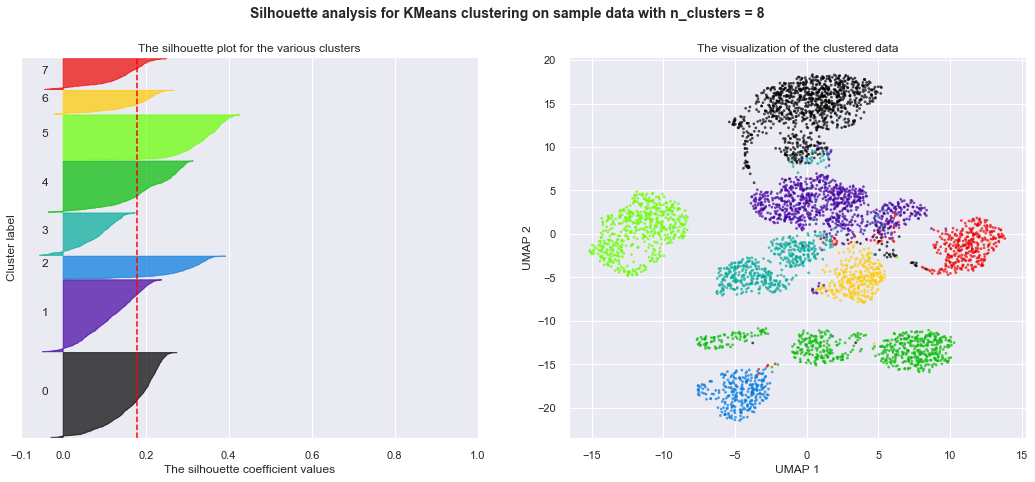

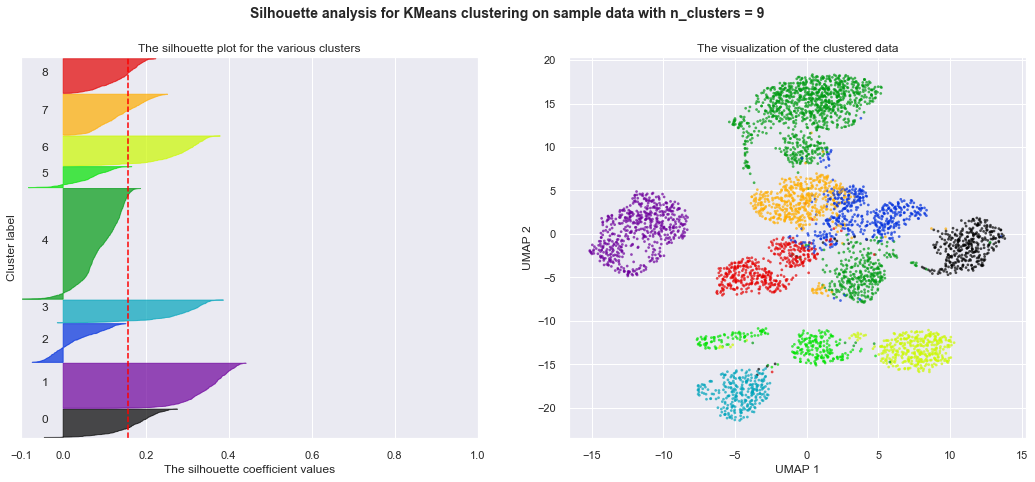

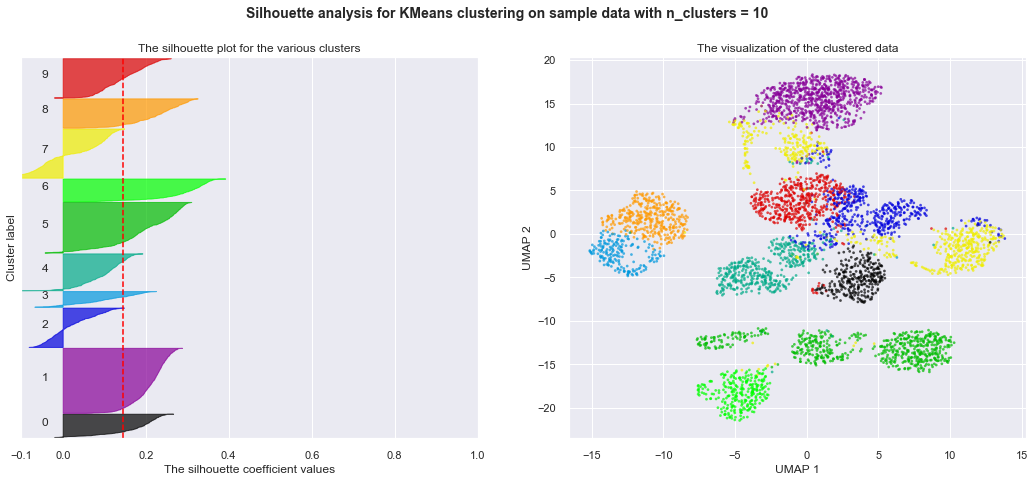

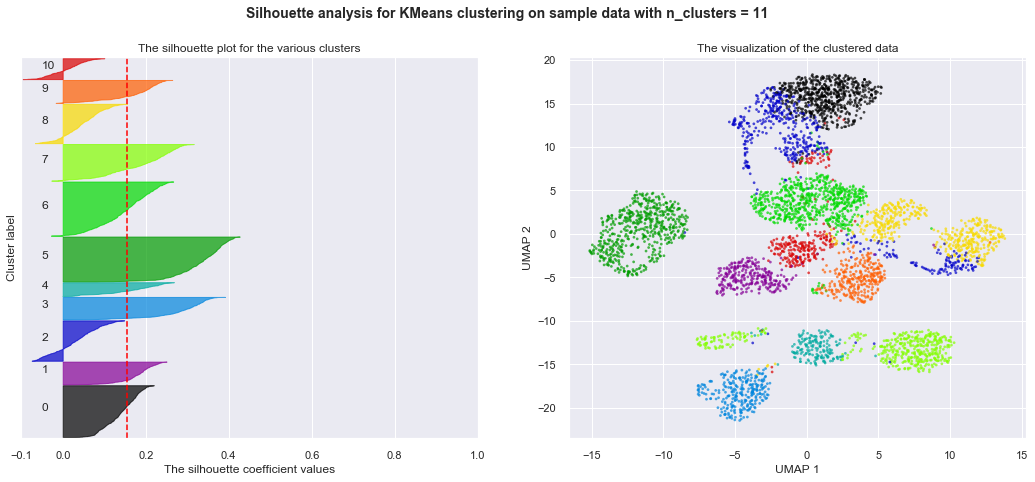

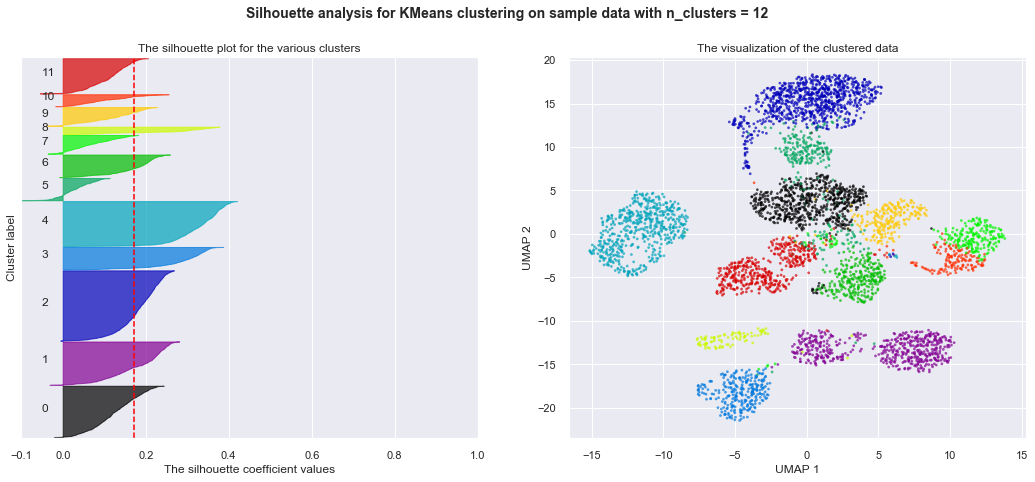

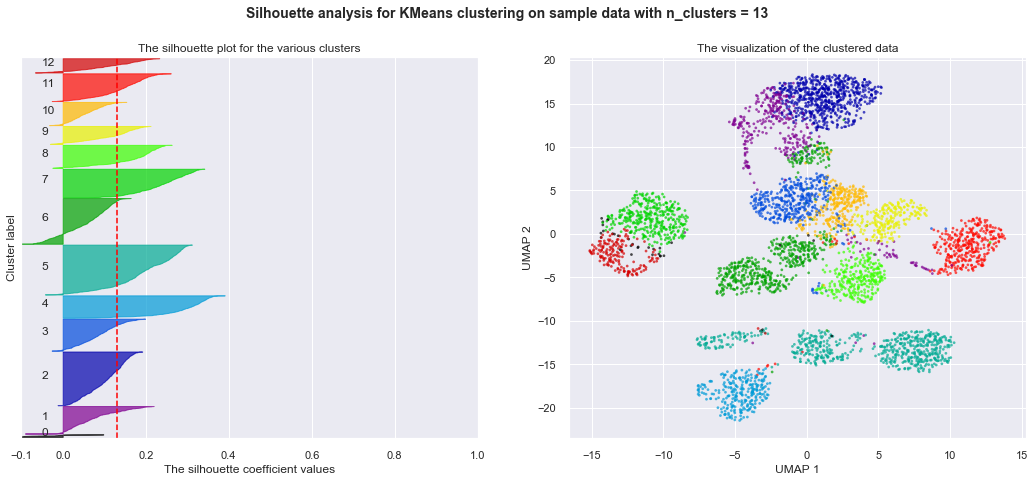

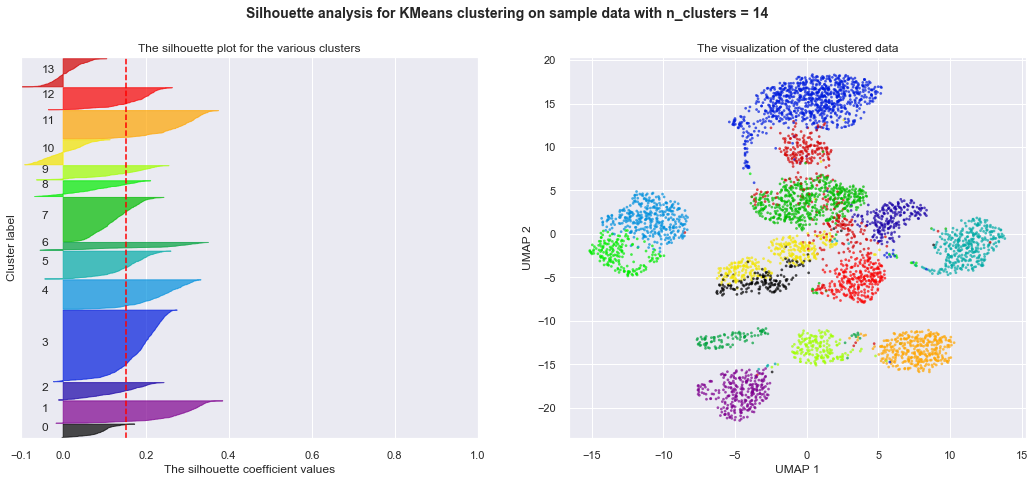

In [13]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

K = range(7,15)
for n_clusters  in K:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # seed of 42 for reproducibility
    km = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = km.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    silhouette_colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(umap_embedding1[:, 0], umap_embedding1[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=silhouette_colors, edgecolor='k')

    ax2.set_title("The visualization of the clustered data")
    ax2.set_xlabel("UMAP 1")
    ax2.set_ylabel("UMAP 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()


# 14. Gaussian mixture models
**Calculation of BIC and AIC**

---Gaussian mixture models (1 components, tied): 0.03892660140991211 seconds ---
---Gaussian mixture models (2 components, tied): 0.08976030349731445 seconds ---
---Gaussian mixture models (3 components, tied): 0.09000802040100098 seconds ---
---Gaussian mixture models (4 components, tied): 0.2608327865600586 seconds ---
---Gaussian mixture models (5 components, tied): 0.3276333808898926 seconds ---
---Gaussian mixture models (6 components, tied): 0.19797945022583008 seconds ---
---Gaussian mixture models (7 components, tied): 0.23636746406555176 seconds ---
---Gaussian mixture models (8 components, tied): 0.30420994758605957 seconds ---
---Gaussian mixture models (9 components, tied): 0.6553094387054443 seconds ---
---Gaussian mixture models (10 components, tied): 0.6253623962402344 seconds ---
---Gaussian mixture models (11 components, tied): 0.797396183013916 seconds ---
---Gaussian mixture models (12 components, tied): 1.6418375968933105 seconds ---
---Gaussian mixture models (13 c

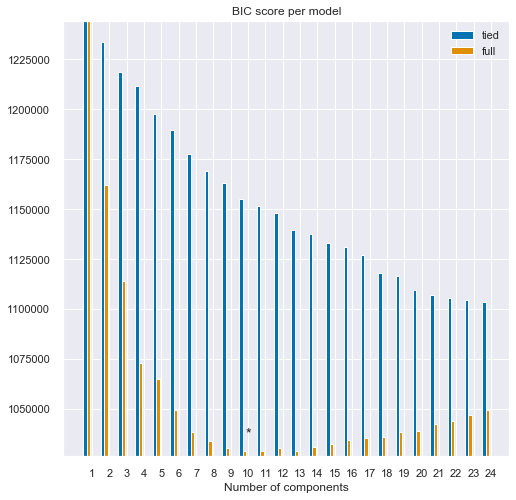

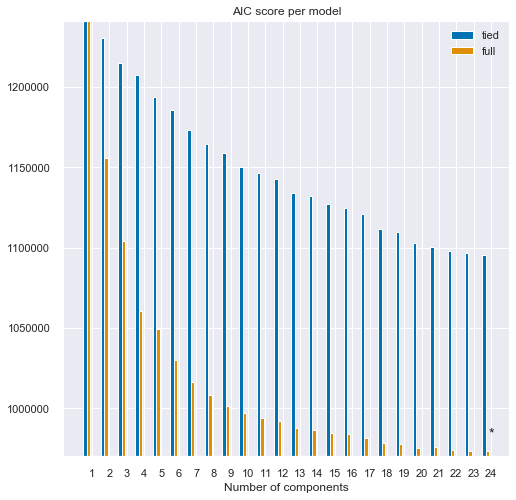

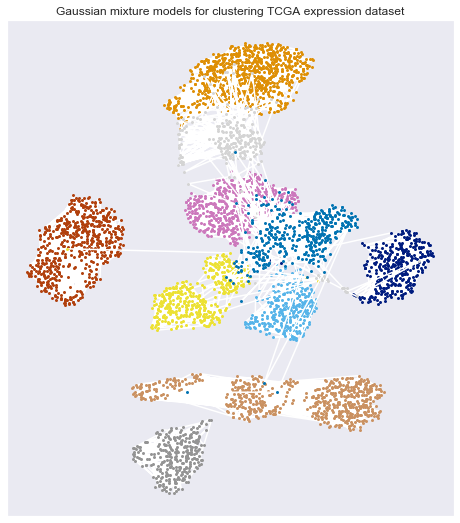

In [14]:
#from https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html

import numpy as np
import itertools

from scipy import linalg
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
lowest_aic = np.infty
bic = []
aic=[]
n_components_range = range(1, 25)
cv_types = ['tied', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type, random_state=42)
        start_time = time.time()
        #gmm.fit(X) #takes ages..
        gmm.fit(X_pca) 
        print("---Gaussian mixture models (%s components, %s): %s seconds ---" % (n_components,cv_type,time.time() - start_time))

        #bic.append(gmm.bic(X))
        bic.append(gmm.bic(X_pca))
        aic.append(gmm.aic(X_pca))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]

bic = np.array(bic)
aic = np.array(aic)

color_iter = colors[0:len(bic)]
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 8))    
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)


# Plot the AIC scores
plt.figure(figsize=(8, 8))    
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, aic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([aic.min() * 1.01 - .01 * aic.max(), aic.max()])
plt.title('AIC score per model')
xpos = np.mod(aic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(aic.argmin() / len(n_components_range))
plt.text(xpos, aic.min() * 0.97 + .03 * aic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)

# Plot the winner
plt.figure(figsize=(8, 8))    
#labels_pred = clf.predict(X)
labels_pred = clf.predict(X_pca)

cluster_centers = [] #to get colors:
for lab in np.unique(labels_pred):
    cluster_centers.append(X.loc[labels_pred==lab].mean(axis=0))

order = pairwise_distances_argmin(cluster_centers,cancer_centers)
newcolors=getnewcolors(order,colors)    
n_clusters=len(cluster_centers)
        
for k, col in zip(range(n_clusters), newcolors):
    my_members = labels_pred == k
    plt.plot(umap_embedding1[my_members, 0], umap_embedding1[my_members, 1], 'w',
            markerfacecolor=col, marker='.')    
plt.title("Gaussian mixture models for clustering TCGA expression dataset")    


plt.xticks(())
plt.yticks(())
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

## How to check clustering accuracy? (supervised)
**15. Adjusted Rand index, Normalized Mutual Information, V-measure**

ARI: Best value: 0.7478578244190822, best k: 8
NMI: Best value: 0.8178564247463653, best k: 19
V-measure: Best value: 0.8178564247463653, best k: 19


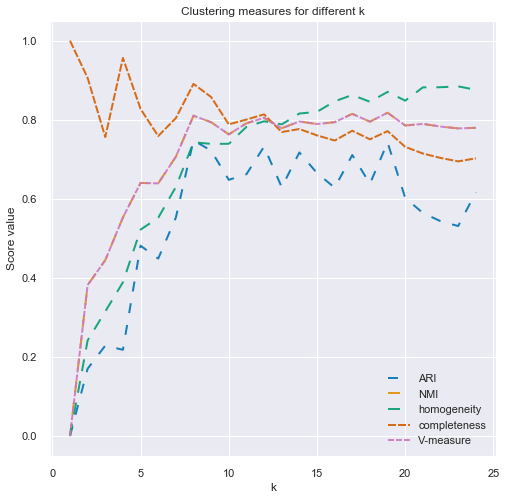

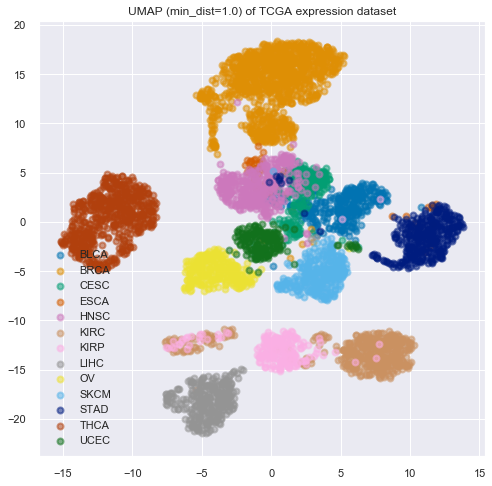

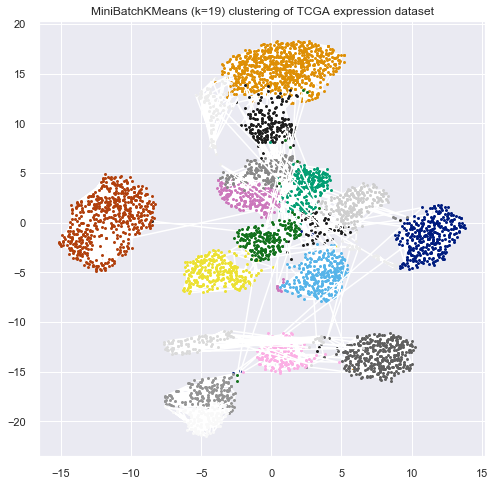

In [15]:
from sklearn import metrics
import random

#from https://scikit-learn.org/stable/auto_examples/cluster/plot_adjusted_for_chance_measures.html
 
labels_true = y

ARI=[]
adjusted_MI=[]
NMI=[]
homogeneity=[]
completeness=[]
Vmeasure=[]

K = range(1,25)

for k in K:
    km = MiniBatchKMeans(n_clusters=k, random_state=42)
    labels_pred = km.fit_predict(X)
    ARI.append(metrics.adjusted_rand_score(labels_true, labels_pred))   
    adjusted_MI.append(metrics.adjusted_mutual_info_score(labels_true, labels_pred))   
    NMI.append(metrics.normalized_mutual_info_score(labels_true, labels_pred))   
    homogeneity.append(metrics.homogeneity_score(labels_true, labels_pred)) 
    completeness.append(metrics.completeness_score(labels_true, labels_pred)) 
    Vmeasure.append(metrics.v_measure_score(labels_true, labels_pred)) 
 
measures=[ARI,NMI,homogeneity,completeness,Vmeasure]
labels=["ARI","NMI","homogeneity","completeness","V-measure"]      
  
plt.figure(figsize=(8, 8))   
for color, values, label in zip(colors[0:len(measures)], measures, labels):
    plt.plot(K, values, 'bx-',color=color, label=label, alpha=0.9,lw=2,dashes=[random.randint(1,6),random.randint(1,6)])

plt.xlabel('k')
plt.ylabel('Score value')
plt.title('Clustering measures for different k')
plt.legend(loc="best", shadow=False)
   
bestK=K[np.argmax(ARI)]
print("ARI: Best value: {}, best k: {}".format(np.max(ARI), bestK))
bestK=K[np.argmax(NMI)]
print("NMI: Best value: {}, best k: {}".format(np.max(NMI), bestK))
bestK=K[np.argmax(Vmeasure)]
print("V-measure: Best value: {}, best k: {}".format(np.max(Vmeasure), bestK))


title="UMAP (min_dist=1.0)"
plt.figure(figsize=(8, 8))
for color, i, target_name in zip(colors, range(num_cancer_type), np.unique(y)):
    plt.scatter(umap_embedding1[y == target_name, 0], umap_embedding1[y == target_name, 1],
                    color=color, lw=2, label=target_name, alpha=0.5)
plt.title(title + " of TCGA expression dataset")
plt.legend(loc="best", shadow=False, scatterpoints=1)

km = MiniBatchKMeans(n_clusters=bestK, random_state=42)
km.fit(X)
title="MiniBatchKMeans (k="+str(bestK)+")"
plt.figure(figsize=(8, 8))    
# We want to have the same colors as in the original dataset (if possible)
cluster_centers = km.cluster_centers_

order = pairwise_distances_argmin(cluster_centers,cancer_centers)
newcolors=getnewcolors(order,colors)

k_means_labels = km.fit_predict(X)

n_clusters=len(cluster_centers)
for k, col in zip(range(n_clusters), newcolors):
    my_members = k_means_labels == k
    cluster_center = cluster_centers[k]
    plt.plot(umap_embedding1[my_members, 0], umap_embedding1[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
plt.title(title + " clustering of TCGA expression dataset")

plt.show()
  


## 16. Spectral Clustering
**Execution time: 1030 seconds - do not run during the class**

---SpectralClustering (affinity='nearest_neighbors'): 1102.7377972602844 seconds ---
ARI: 0.8148197544022105
NMI: 0.8670934506516998
V-measure: 0.8670934506516997


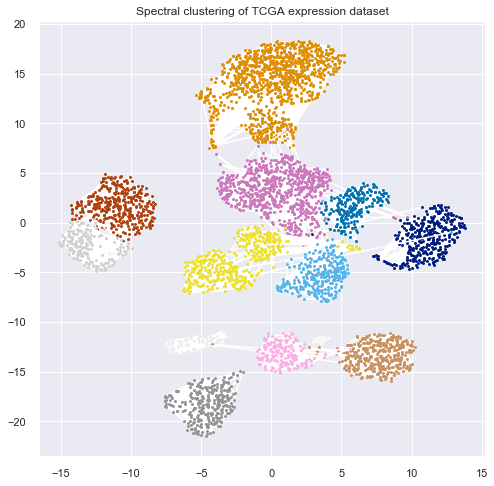

In [16]:
from sklearn.cluster import SpectralClustering

trueK=len(np.unique(labels_true))

start_time = time.time()
clustering = SpectralClustering(n_clusters=trueK, assign_labels="kmeans", 
                                affinity='nearest_neighbors' ,random_state=42).fit(X)
print("---SpectralClustering (affinity='nearest_neighbors'): %s seconds ---" % (time.time() - start_time))

labels_pred = clustering.labels_

ARI=metrics.adjusted_rand_score(labels_true, labels_pred)
NMI=metrics.normalized_mutual_info_score(labels_true, labels_pred)  
homogeneity=metrics.homogeneity_score(labels_true, labels_pred)
completeness=metrics.completeness_score(labels_true, labels_pred)
Vmeasure=metrics.v_measure_score(labels_true, labels_pred)

print("ARI: {}". format(ARI))
print("NMI: {}". format(NMI))
print("V-measure: {}". format(Vmeasure))

plt.figure(figsize=(8, 8))    
    
cluster_centers = [] #here we only calculate them to get colors. Does not make sense in general case.
for lab in np.unique(labels_pred):
    cluster_centers.append(X.loc[labels_pred==lab].mean(axis=0))

order = pairwise_distances_argmin(cluster_centers,cancer_centers)
newcolors=getnewcolors(order,colors)    
n_clusters=len(cluster_centers)
for k, col in zip(range(n_clusters), newcolors):
    my_members = labels_pred == k
    cluster_center = cluster_centers[k]
    plt.plot(umap_embedding1[my_members, 0], umap_embedding1[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
plt.title("Spectral clustering of TCGA expression dataset")
plt.show()

## 17. Hierarchical clustering (Ward Linkage)
**Execution time: 711 sec**

---Hierarchical clustering (linkage='ward'): 354.79378151893616 seconds ---
---Hierarchical clustering (linkage='ward', knn connectivity): 314.41276454925537 seconds ---
Hierarchical clustering (Ward linkage): ARI: 0.73939652138324
Hierarchical clustering (Ward linkage): NMI: 0.8379409368980142
Hierarchical clustering (Ward linkage): V-measure: 0.8379409368980141
Hierarchical clustering (Ward linkage, with connectivity): ARI: 0.73939652138324
Hierarchical clustering (Ward linkage, with connectivity): NMI: 0.8379409368980142
Hierarchical clustering (Ward linkage, with connectivity): V-measure: 0.8379409368980141


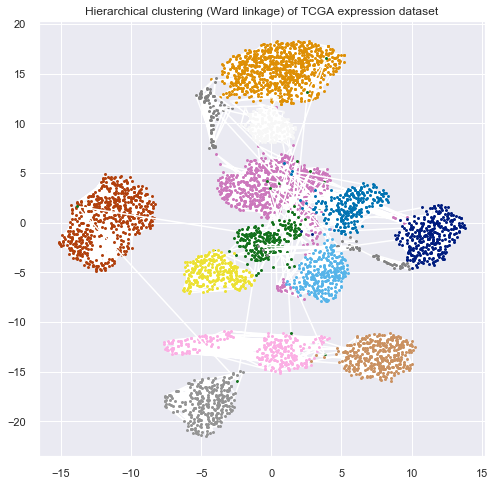

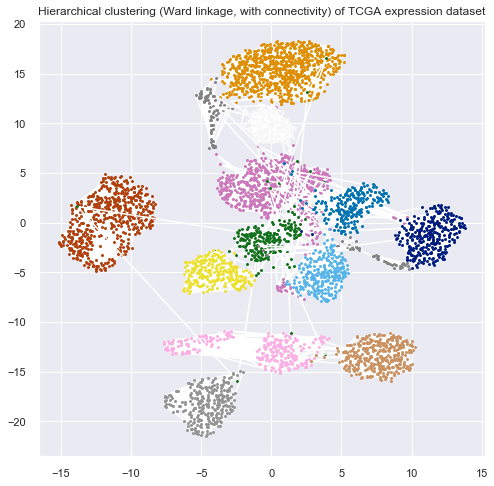

In [17]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

trueK=len(np.unique(labels_true))
ward = AgglomerativeClustering(
        n_clusters=trueK, linkage='ward')
#ward_with_connectivity = AgglomerativeClustering(
#        n_clusters=trueK, linkage='ward', connectivity=kneighbors_graph(X, 15, include_self=False)) #takes ages with real X

ward_with_connectivity = AgglomerativeClustering(
        n_clusters=trueK, linkage='ward', connectivity=kneighbors_graph(X_pca, 40, include_self=False))

start_time = time.time()
ward.fit(X)
print("---Hierarchical clustering (linkage='ward'): %s seconds ---" % (time.time() - start_time))

start_time = time.time()
ward_with_connectivity.fit(X)
print("---Hierarchical clustering (linkage='ward', knn connectivity): %s seconds ---" % (time.time() - start_time))

for clustering, title in [(ward, "Hierarchical clustering (Ward linkage)"), 
                          (ward_with_connectivity, "Hierarchical clustering (Ward linkage, with connectivity)")]:
    labels_pred = ward.labels_
    ARI=metrics.adjusted_rand_score(labels_true, labels_pred)
    NMI=metrics.normalized_mutual_info_score(labels_true, labels_pred)  
    homogeneity=metrics.homogeneity_score(labels_true, labels_pred)
    completeness=metrics.completeness_score(labels_true, labels_pred)
    Vmeasure=metrics.v_measure_score(labels_true, labels_pred)

    print(title+": ARI: {}". format(ARI))
    print(title+": NMI: {}". format(NMI))
    print(title+": V-measure: {}". format(Vmeasure))

    plt.figure(figsize=(8, 8))    
    
    cluster_centers = [] #here we only calculate them to get colors. 
    for lab in np.unique(labels_pred):
        cluster_centers.append(X.loc[labels_pred==lab].mean(axis=0))

    order = pairwise_distances_argmin(cluster_centers,cancer_centers)
    newcolors=getnewcolors(order,colors)    
    n_clusters=len(cluster_centers)
    for k, col in zip(range(n_clusters), newcolors):
        my_members = labels_pred == k
        cluster_center = cluster_centers[k]
        plt.plot(umap_embedding1[my_members, 0], umap_embedding1[my_members, 1], 'w',
            markerfacecolor=col, marker='.')    
    plt.title(title + " of TCGA expression dataset")    
plt.show()



**18. Plot dendrogram:**

---Hierarchical clustering (linkage='ward', full tree): 280.414311170578 seconds ---


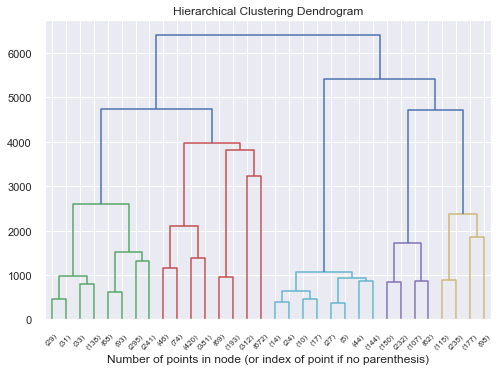

In [18]:
from scipy.cluster.hierarchy import dendrogram

#from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
    
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0.5, n_clusters=None)

start_time = time.time()
model = model.fit(X)
print("---Hierarchical clustering (linkage='ward', full tree): %s seconds ---" % (time.time() - start_time))

plt.title('Hierarchical Clustering Dendrogram')
# plot the top four levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

## 19. Calculate NMI and ARI for Gaussian mixture models (k=13)

In [19]:
#we should still have the best GMM with k=13 as "best_gmm" from snippet 14 
labels_pred = best_gmm.predict(X_pca) #as we trained the model on the projections of X on PCs
#we also have "labels_true" object with information about true cancer types

#ARI=...
#NMI=...  

#print("ARI: {}". format(ARI))
#print("NMI: {}". format(NMI))

Check other clustering methods at https://scikit-learn.org/stable/modules/clustering.html# 

More methods for unsupervised analysis: https://scikit-learn.org/stable/unsupervised_learning.html
including outlier detection, signal deconvolution, and biclustering

And imputation of missing values: https://scikit-learn.org/stable/modules/impute.html